In [1]:
import re
import matplotlib.pyplot as plt
import nltk
from collections import Counter
import seaborn as sns
# Download Gutenberg corpus
nltk.download('gutenberg')
from nltk.corpus import gutenberg

# 文書読み込み
fileids = gutenberg.fileids()
docs = [gutenberg.raw(fid) for fid in fileids]

import numpy as np

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/takatakiyugo/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [2]:
def tokenize_en(text):
    """英語テキストを小文字化して単語リストに分割する簡易トークナイザ"""
    return re.findall(r"[a-zA-Z]+", text.lower())


In [3]:
def show_postings(label, postings, k=30):
    print(f"{label}: df={len(postings)} head={postings[:k]}")


### 文書のチャンキング
500ワードごとに分割して文書数を増やす。RAGなどにも利用可能。

In [4]:
def chunk_documents(docs, chunk_size=500):
    chunks = []
    for doc in docs:
        words = tokenize_en(doc)
        for i in range(0, len(words), chunk_size):
            chunk = " ".join(words[i:i+chunk_size])
            chunks.append(chunk)
    return chunks

chunked_docs = chunk_documents(docs, 500)
print("Original docs:", len(docs))
print("Chunked docs:", len(chunked_docs))


Original docs: 18
Chunked docs: 4279


## Part 1: English (Gutenberg) EDA
Exploratory Data Analysis on English texts from the Gutenberg corpus.

### EDAの目的（英語コーパス）
- 文書数を把握する  
- 各文書の文字数・単語数を確認する  
- 総単語数・ユニーク単語数を確認する  
- 上位頻出単語（Top10）を確認する  
- 出現頻度が1回のみの単語（hapax legomena）の割合を確認する  
- 文書長（単語数）の分布をヒストグラムで確認する  
- 頻出単語 Top20 を棒グラフで可視化する  
- Zipf則（頻度 vs 順位の対数プロット）を確認する  


### Preview Gutenberg Data
Let's check the first few lines of the Gutenberg corpus files to understand the content.

In [5]:

print("Available Gutenberg file IDs:", fileids)
for fid in fileids[:3]:
    print("\n---", fid, "---")
    print(gutenberg.raw(fid)[:500])  # 最初の500文字だけ表示


Available Gutenberg file IDs: ['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']

--- austen-emma.txt ---
[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t

--- austen-persuasion.t

### 文書情報の確認

=== 文書情報 ===


,fileid,chars,words
0,austen-emma.txt,887071,192427
1,austen-persuasion.txt,466292,98171
2,austen-sense.txt,673022,141576
3,bible-kjv.txt,4332554,1010654
4,blake-poems.txt,38153,8354
5,bryant-stories.txt,249439,55563
6,burgess-busterbrown.txt,84663,18963
7,carroll-alice.txt,144395,34110
8,chesterton-ball.txt,457450,96996
9,chesterton-brown.txt,406629,86063



=== コーパス全体の統計 ===
全体文書数: 18
総トークン数: 2,135,400
ユニーク単語数: 41,487

=== 頻度上位 10 単語 ===
the        133,583
and        95,442
of         71,267
to         48,057
a          33,960
in         33,580
i          30,265
that       28,798
he         25,857
it         22,303

=== Hapax (出現1回の単語) ===
数: 15,002
割合: 36.16%


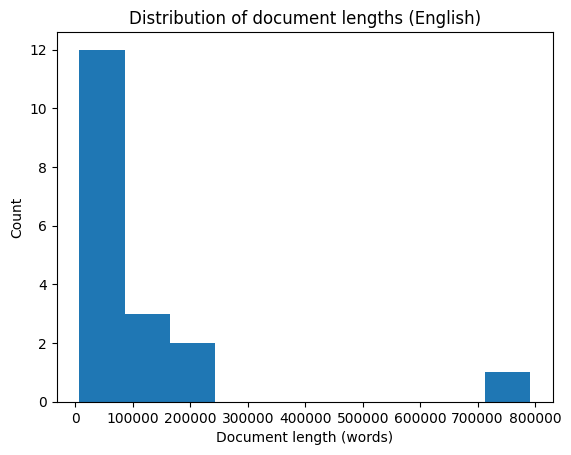

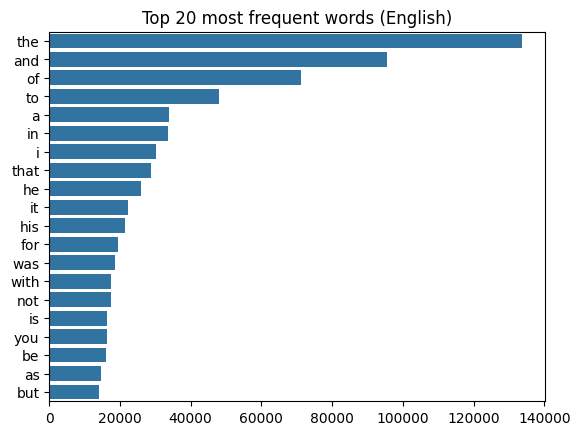

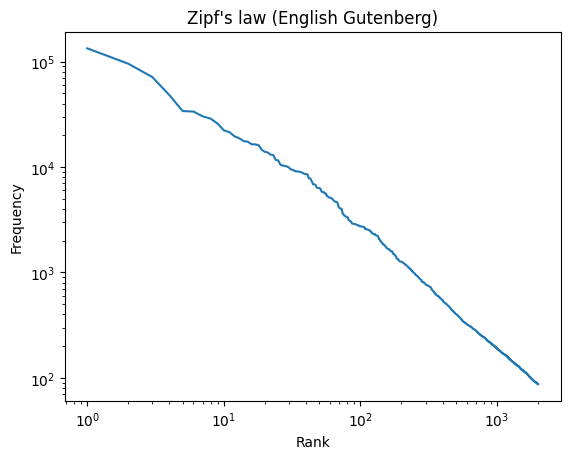

In [6]:
import pandas as pd

# 文書統計
doc_stats = []
for fid in fileids:
    doc_stats.append({
        "fileid": fid,
        "chars": len(gutenberg.raw(fid)),
        "words": len(gutenberg.words(fid))
    })

df_stats = pd.DataFrame(doc_stats)
print("=== 文書情報 ===")
display(df_stats)

# トークンと語彙
tokens_en = [w.lower() for fid in fileids for w in gutenberg.words(fid) if w.isalpha()]
vocab_en = set(tokens_en)

freq_en = Counter(tokens_en)
hapax_en = [w for w,c in freq_en.items() if c==1]

# コーパス全体統計
print("\n=== コーパス全体の統計 ===")
print(f"全体文書数: {len(fileids)}")
print(f"総トークン数: {len(tokens_en):,}")
print(f"ユニーク単語数: {len(vocab_en):,}")

# 頻度上位10
print("\n=== 頻度上位 10 単語 ===")
for w, f in freq_en.most_common(10):
    print(f"{w:<10} {f:,}")

# Hapax
print("\n=== Hapax (出現1回の単語) ===")
print(f"数: {len(hapax_en):,}")
print(f"割合: {len(hapax_en)/len(vocab_en):.2%}")

# 文書長分布
doc_lengths = [len([w for w in gutenberg.words(fid) if w.isalpha()]) for fid in fileids]
plt.hist(doc_lengths, bins=10)
plt.xlabel("Document length (words)")
plt.ylabel("Count")
plt.title("Distribution of document lengths (English)")
plt.show()

# Top 20 words
top20 = freq_en.most_common(20)
words, counts = zip(*top20)
sns.barplot(x=list(counts), y=list(words))
plt.title("Top 20 most frequent words (English)")
plt.show()

# Zipf's law
ranks, freqs = zip(*[(r+1, f) for r,(w,f) in enumerate(freq_en.most_common(2000))])
plt.loglog(ranks, freqs)
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf's law (English Gutenberg)")
plt.show()


### 単語長の分布

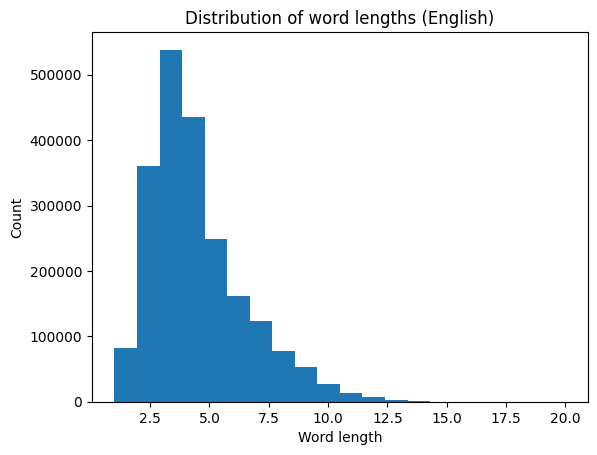

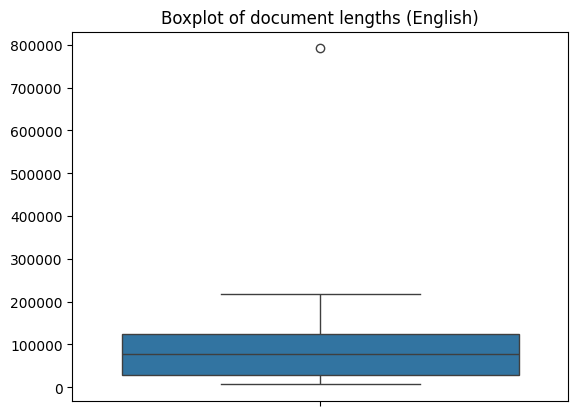

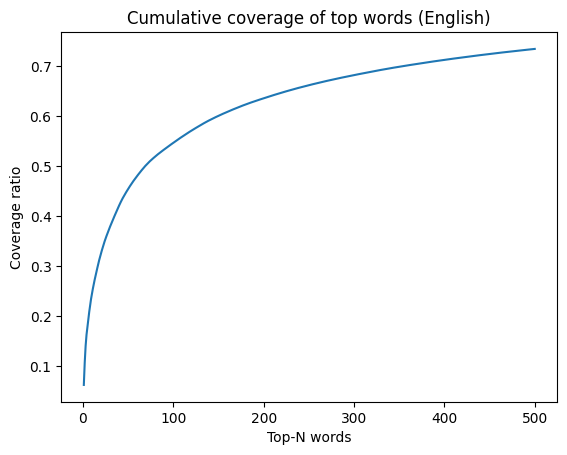

Top 10 bigrams:
('of', 'the') 19134
('in', 'the') 10244
('and', 'the') 8879
('the', 'lord') 7081
('to', 'the') 5413
('all', 'the') 3600
('and', 'he') 3591
('to', 'be') 3468
('for', 'the') 3049
('shall', 'be') 2791

Top 10 trigrams:
('of', 'the', 'lord') 1780
('the', 'son', 'of') 1466
('the', 'children', 'of') 1368
('out', 'of', 'the') 1202
('the', 'house', 'of') 917
('saith', 'the', 'lord') 854
('the', 'lord', 'and') 818
('and', 'i', 'will') 764
('and', 'all', 'the') 697
('children', 'of', 'israel') 647


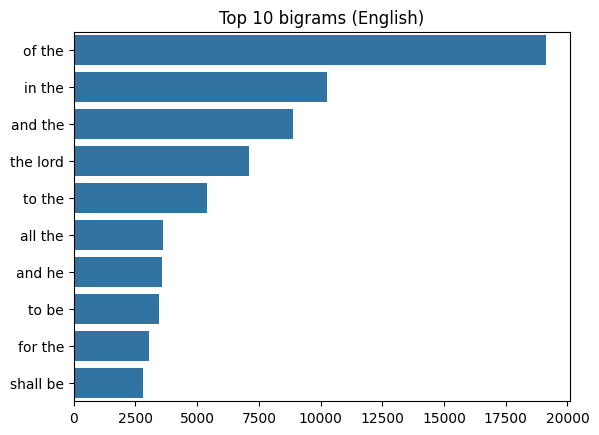

In [7]:
# 単語長の分布
word_lengths = [len(w) for w in tokens_en]
plt.hist(word_lengths, bins=20)
plt.xlabel("Word length")
plt.ylabel("Count")
plt.title("Distribution of word lengths (English)")
plt.show()

# 文書長の箱ひげ図
sns.boxplot(y=doc_lengths)
plt.title("Boxplot of document lengths (English)")
plt.show()

# 上位単語の累積カバー率
cum_freqs = np.cumsum([f for w,f in freq_en.most_common(500)])
cum_ratio = cum_freqs / sum(freq_en.values())
plt.plot(range(1,501), cum_ratio)
plt.xlabel("Top-N words")
plt.ylabel("Coverage ratio")
plt.title("Cumulative coverage of top words (English)")
plt.show()

# Bigram / Trigram 分析
from nltk import ngrams

bigrams = list(ngrams(tokens_en, 2))
trigrams = list(ngrams(tokens_en, 3))

bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

print("Top 10 bigrams:")
for bg, f in bigram_freq.most_common(10):
    print(bg, f)

print("\nTop 10 trigrams:")
for tg, f in trigram_freq.most_common(10):
    print(tg, f)

# 可視化 Bigram Top10
top10_bigrams = bigram_freq.most_common(10)
labels = [" ".join(bg) for bg,_ in top10_bigrams]
counts = [c for _,c in top10_bigrams]
sns.barplot(x=counts, y=labels)
plt.title("Top 10 bigrams (English)")
plt.show()


### 前処理の効果 (Stopword 除去 + Stemming)

### 前処理の効果（Stopword 除去 + Stemming）

Stopword: theとかofとか不必要な単語を抜く

stemming: 三単現や複数形のsを抜く

In [8]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokens_cleaned = [stemmer.stem(w) for w in tokens_en if w not in stop_words]
freq_cleaned = Counter(tokens_cleaned)

print("Before preprocessing:")
print("  Unique vocab:", len(vocab_en))
print("  Top 10 words:", freq_en.most_common(10))

print("\nAfter stopword removal + stemming:")
print("  Unique vocab:", len(set(tokens_cleaned)))
print("  Top 10 words:", freq_cleaned.most_common(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/takatakiyugo/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Before preprocessing:
  Unique vocab: 41487
  Top 10 words: [('the', 133583), ('and', 95442), ('of', 71267), ('to', 48057), ('a', 33960), ('in', 33580), ('i', 30265), ('that', 28798), ('he', 25857), ('it', 22303)]

After stopword removal + stemming:
  Unique vocab: 25463
  Top 10 words: [('shall', 11682), ('said', 9434), ('unto', 9010), ('lord', 8671), ('thou', 6759), ('one', 6408), ('god', 5673), ('man', 5644), ('thi', 5609), ('ye', 5350)]


### 前処理の効果の可視化

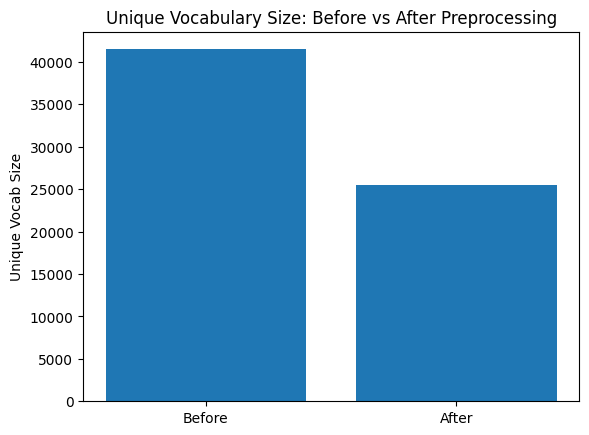

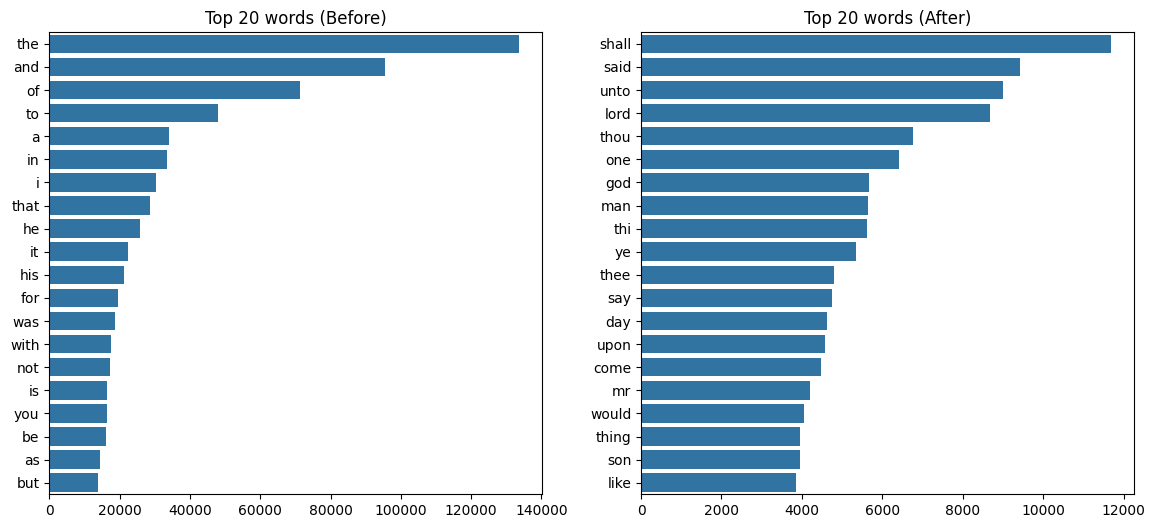

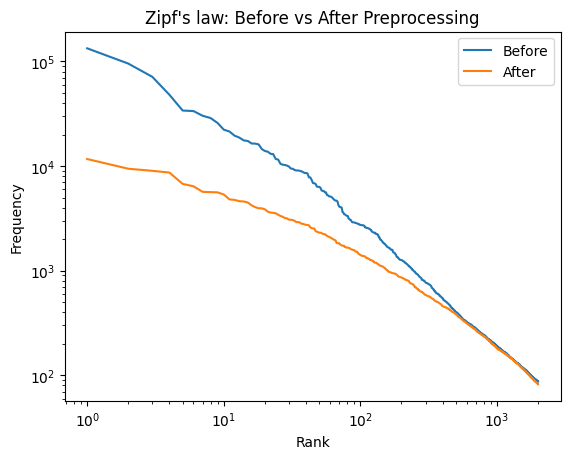

In [9]:
# 可視化1: ユニーク語彙数の比較
before_vocab = len(vocab_en)
after_vocab = len(set(tokens_cleaned))

plt.bar(["Before", "After"], [before_vocab, after_vocab])
plt.ylabel("Unique Vocab Size")
plt.title("Unique Vocabulary Size: Before vs After Preprocessing")
plt.show()

# 可視化2: 頻度分布 Top20 比較
top20_before = freq_en.most_common(20)
top20_after = freq_cleaned.most_common(20)

fig, axes = plt.subplots(1, 2, figsize=(14,6))
words_b, counts_b = zip(*top20_before)
sns.barplot(x=list(counts_b), y=list(words_b), ax=axes[0])
axes[0].set_title("Top 20 words (Before)")

words_a, counts_a = zip(*top20_after)
sns.barplot(x=list(counts_a), y=list(words_a), ax=axes[1])
axes[1].set_title("Top 20 words (After)")
plt.show()

# 可視化3: Zipf則の比較
ranks_b, freqs_b = zip(*[(r+1, f) for r,(w,f) in enumerate(freq_en.most_common(2000))])
ranks_a, freqs_a = zip(*[(r+1, f) for r,(w,f) in enumerate(freq_cleaned.most_common(2000))])

plt.loglog(ranks_b, freqs_b, label="Before")
plt.loglog(ranks_a, freqs_a, label="After")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Zipf's law: Before vs After Preprocessing")
plt.legend()
plt.show()


top20wordsで、thisがthiになったりしているが、stopwordsとはそういうもの


## まとめ

- データの基本統計量や分布を把握することで、異常値や欠損値、データの偏りを早期に発見できる。
- 可視化によって特徴量間の関係性や傾向を直感的に理解できる。
- 前処理・特徴量設計・モデル設計に向けた重要なインサイトを得ることができる。

EDAは単なる確認作業ではなく、後続の分析やモデル化の成否を大きく左右する重要なプロセスである。


目的に応じた前処理が必要（例えば、"I am Sum"という映画について述べているとき、I amが失われる